This notebook will give an introduction to the Hugging Face Transformers Python library and some common patterns that you can use to take advantage of it. It is most useful for using or fine-tuning pretrained transformer models for your projects.

Hugging Face provides access to models (both the code that implements them and their pre-trained weights), model-specific tokenizers, as well as pipelines for common NLP tasks, and datasets and metrics in a separate `datasets` package. It has implementations in PyTorch, and Tensorflow.

Here are additional resources introducing the library that were used to make this tutorial:

* [Hugging Face Docs](https://huggingface.co/docs/transformers/index)
  * Clear documentation
  * Tutorials, walk-throughs, and example notebooks
  * List of available models
* [Hugging Face Course](https://huggingface.co/course/)


In [1]:
# !pip install transformers[torch]
# !pip install datasets

^C


In [ ]:
from collections import defaultdict, Counter
import json

from matplotlib import pyplot as plt
import numpy as np
import torch

def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

## 1. Common Pattern for using Hugging Face Transformers

We're going to start off with a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis.

First, find a model on [the hub](https://huggingface.co/models). Anyone can upload their model for other people to use. (I'm using a sentiment analysis model from [this paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3489963)).

Then, there are two objects that need to be initialized - a **tokenizer**, and a **model**

* Tokenizer converts strings to lists of vocabulary ids that the model requires
* Model takes the vocabulary ids and produces a prediction

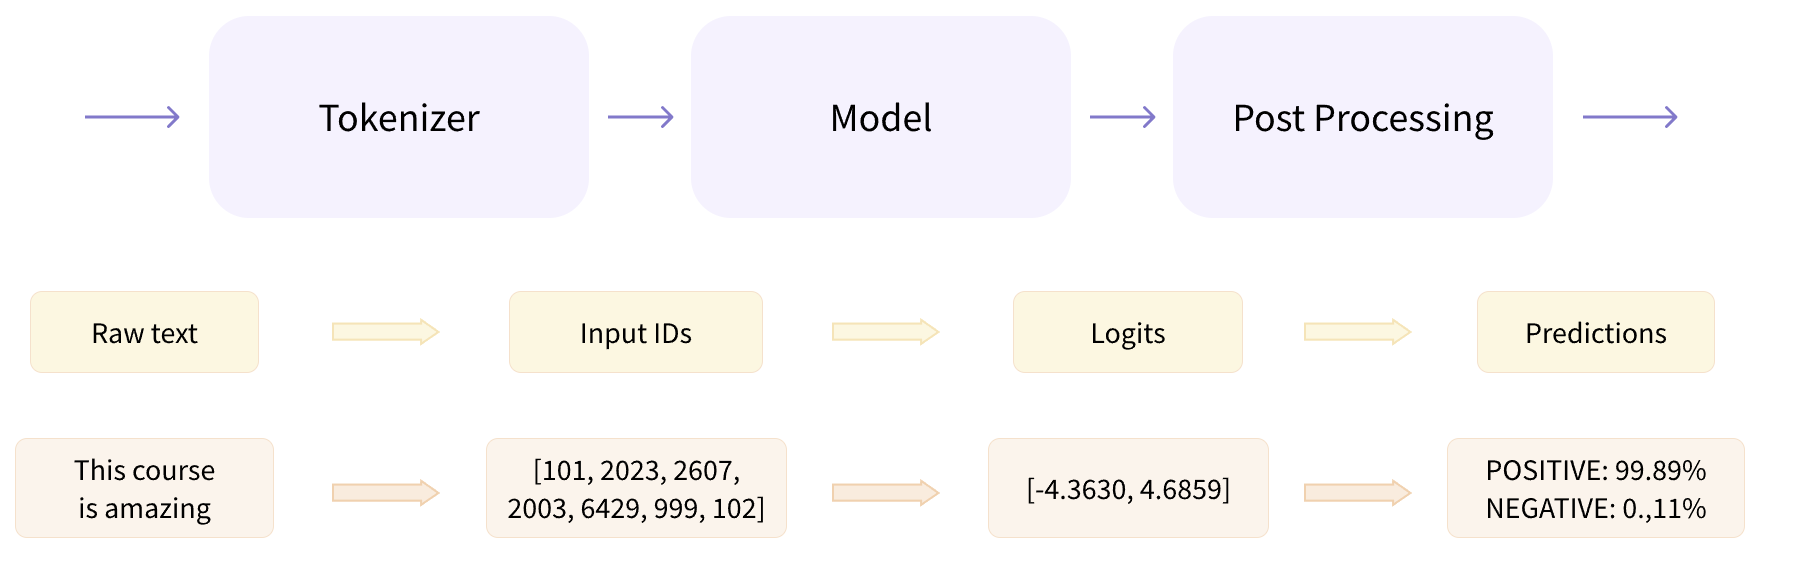

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("siebert/sentiment-roberta-large-english")
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained("siebert/sentiment-roberta-large-english")

In [ ]:
inputs = "I'm excited to learn about Hugging Face Transformers!"
tokenized_inputs = tokenizer(inputs, return_tensors="pt")
outputs = model(**tokenized_inputs)

labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)


print("Input:")
print(inputs)
print()
print("Tokenized Inputs:")
print_encoding(tokenized_inputs)
print()
print("Model Outputs:")
print(outputs)
print()
print(f"The prediction is {labels[prediction]}")

### 1.1 Tokenizers

Pretrained models are implemented along with **tokenizers** that are used to preprocess their inputs. The tokenizers take raw strings or list of strings and output what are effectively dictionaries that contain the the model inputs.


You can access tokenizers either with the Tokenizer class specific to the model you want to use (here DistilBERT), or with the AutoTokenizer class.
Fast Tokenizers are written in Rust, while their slow versions are written in Python.

In [ ]:
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")      # written in Python
print(tokenizer)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")  # written in Rust
print(tokenizer)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased") # convenient! Defaults to Fast
print(tokenizer)

In [ ]:
# This is how you call the tokenizer
input_str = "Hugging Face Transformers is great!"
tokenized_inputs = tokenizer(input_str)


print("Vanilla Tokenization")
print_encoding(tokenized_inputs)
print()

# Two ways to access:
print(tokenized_inputs.input_ids)
print(tokenized_inputs["input_ids"])

In [ ]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(input_str)
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print("start:                ", input_str)
print("tokenize:             ", input_tokens)
print("convert_tokens_to_ids:", input_ids)
print("add special tokens:   ", input_ids_special_tokens)
print("--------")
print("decode:               ", decoded_str)

# NOTE that these steps don't create the attention mask or add the special characters

In [ ]:
# You can pass multiple strings into the tokenizer and pad them as you need
model_inputs = tokenizer(["Hugging Face Transformers is great!",
                         "The quick brown fox jumps over the lazy dog." +\
                         "Then the dog got up and ran away because she didn't like foxes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")
print("Padding:")
print_encoding(model_inputs)

In [ ]:
# You can also decode a whole batch at once:
print("Batch Decode:")
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print("Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

For more information about tokenizers, you can look at:
[Hugging Face Transformers Docs](https://huggingface.co/docs/transformers/main_classes/tokenizer) and the [Hugging Face Tokenizers Library](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html) (For the Fast Tokenizers). The Tokenizers Library even lets you train your own tokenizers!

### 1.2. Models

Initializing models is very similar to initializing tokenizers. You can either use the model class specific to your model or you can use an AutoModel class. I tend to prefer AutoModel, especially when I want to compare models, because it's easy to specify the models as strings.

While most of the pretrained transformers have similar architecture, if you there are additional weights, called "heads" that you have to train if you're doing sequence classification, question answering, or some other task. Hugging Face automatically sets up the architecture you need when you specify the model class. For example, we are doing sentiment analysis, so we are going to use `DistilBertForSequenceClassification`. If we were going to continue training DistilBERT on its masked-language modeling training objective, we would use `DistilBertForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `DistilBertModel`

Here are some examples.
```
*
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```
where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)


There are three types of models:
* Encoders (e.g. BERT)
* Decoders (e.g. GPT2)
* Encoder-Decoder models (e.g. BART or T5)

The task-specific classes you have available depend on what type of model you're dealing with.


A full list of choices are available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example DistilBERT is not compatible with the Seq2Seq models because it only consists of an encoder.

In [ ]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

We get a warning here because the sequence classification parameters haven't been trained yet.

Passing inputs to the model is easy. They take inputs as keyword arguments

In [ ]:
model_inputs = tokenizer(input_str, return_tensors="pt")


# Option 1
model_outputs = model(input_ids=model_inputs.input_ids, attention_mask=model_inputs.attention_mask)

# Option 2 - the keys of the dictionary the tokenizer returns are the same as the keyword arguments
#            the model expects

# f({k1: v1, k2: v2}) = f(k1=v1, k2=v2)

model_outputs = model(**model_inputs)



print(model_inputs)
print()
print(model_outputs)
print()
print(f"Distribution over labels: {torch.softmax(model_outputs.logits, dim=1)}")

One final note - you can get the hidden states and attention weights from the models really easily. This is particularly helpful if you're working on an analysis project. (For example, see [What does BERT look at?](https://arxiv.org/abs/1906.04341)).

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained("distilbert-base-cased", output_attentions=True, output_hidden_states=True)
model.eval()

model_inputs = tokenizer(input_str, return_tensors="pt")
with torch.no_grad():
    model_output = model(**model_inputs)


print("Hidden state size (per layer):  ", model_output.hidden_states[0].shape)
print("Attention head size (per layer):", model_output.attentions[0].shape)     # (layer, batch, query_word_idx, key_word_idxs)
                                                                               # y-axis is query, x-axis is key
print(model_output)

# 2. Tuneo

For your projects, you are much more likely to want to finetune a pretrained model. This is a little bit more involved, but is still quite easy.



## 2.1 Data

In addition to having models, the [the hub](https://huggingface.co/datasets) also has datasets.

In [ ]:
from datasets import load_dataset, DatasetDict


imdb_dataset = load_dataset("imdb")

# Just take the first 50 tokens for speed/running on cpu
def truncate(example):
    return {
        'text': " ".join(example['text'].split()[:50]),
        'label': example['label']
    }

# Take 128 random examples for train and 32 validation
small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

In [ ]:
small_imdb_dataset

In [ ]:
small_imdb_dataset['train'][:10]

In [ ]:
small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], padding=True, truncation=True),
    batched=True,
    batch_size=16
)

small_tokenized_dataset = small_tokenized_dataset.remove_columns(["text"])
small_tokenized_dataset = small_tokenized_dataset.rename_column("label", "labels")
small_tokenized_dataset.set_format("torch")

In [ ]:
small_tokenized_dataset['train'][0:2]

## 2.2 Training

Hugging Face offers a powerful `Trainer` class to handle most needs. I think it works pretty well, though there are some customizations I'd recommend

In [ ]:
## Repeat the data loading just to avoid problems

imdb_dataset = load_dataset("imdb")

small_imdb_dataset = DatasetDict(
    train=imdb_dataset['train'].shuffle(seed=1111).select(range(128)).map(truncate),
    val=imdb_dataset['train'].shuffle(seed=1111).select(range(128, 160)).map(truncate),
)

small_tokenized_dataset = small_imdb_dataset.map(
    lambda example: tokenizer(example['text'], truncation=True),
    batched=True,
    batch_size=16
)

`TrainingArguments` specifies different training parameters like how often to evaluate and save model checkpoints, where to save them, etc. There are **many** aspects you can customize and it's worth checking them out [here](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). Some things you can control include:
* learning rate, weight decay, gradient clipping,
* checkpointing, logging, and evaluation frequency
* where you log to (default is tensorboard, but if you use WandB or MLFlow they have integrations)

The `Trainer` actually performs the training. You can pass it the `TrainingArguments`, model, the datasets, tokenizer, optimizer, and even model checkpoints to resume training from. The `compute_metrics` function is called at the end of evaluation/validation to calculate evaluation metrics.

In [ ]:
from transformers import TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2)

arguments = TrainingArguments(
    output_dir="sample_hf_trainer",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    evaluation_strategy="epoch", # run validation at the end of each epoch
    save_strategy="epoch",
    learning_rate=2e-5,
    load_best_model_at_end=True,
    seed=224
)


def compute_metrics(eval_pred):
    """Called at the end of validation. Gives accuracy"""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # calculates the accuracy
    return {"accuracy": np.mean(predictions == labels)}


trainer = Trainer(
    model=model,
    args=arguments,
    train_dataset=small_tokenized_dataset['train'],
    eval_dataset=small_tokenized_dataset['val'], # change to test when you do your final evaluation!
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#### 2.2.1 Callbacks: Logging and Early Stopping


Hugging Face Transformers also allows you to write `Callbacks` if you want certain things to happen at different points during training (e.g. after evaluation or after an epoch has finished). For example, there is a callback for early stopping, and I usually write one for logging as well.

For more information on callbacks see [here](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback).

In [ ]:
from transformers import TrainerCallback, EarlyStoppingCallback

class LoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero:
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")


trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))
trainer.add_callback(LoggingCallback("sample_hf_trainer/log.jsonl"))

In [ ]:
trainer.train()

Included here are also some practical tips for fine-tuning:

**Good default hyperparameters.** The hyperparameters you will depend on your task and dataset. You should do a hyperparameter search to find the best ones. That said, here are some good initial values for fine-tuning.
* Epochs: {2, 3, 4} (larger amounts of data need fewer epochs)
* Batch size (bigger is better: as large as you can make it)
* Optimizer: AdamW
* AdamW learning rate: {2e-5, 5e-5}

You should monitor your validation loss to decide when you've found good hyperparameters.

There's a lot more that we can integrate into the Trainer to make it more useful including logging, saving model checkpoints, and more! You can even sub-class it to add your own personalized components. You can check out [this link](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) for more information about the Trainer.

In [ ]:
results = trainer.predict(small_tokenized_dataset['val'])
results